# Initialize the accelerator

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/home/xilinx/radioml_deploy'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from driver.driver_base import FINNExampleOverlay
from finn.core.datatype import DataType

In [2]:
# taken from generated driver.py:
io_shape_dict = {
    # FINN DataType for input and output tensors
    "idt" : DataType.INT8,
    "odt" : DataType.INT16,
    # shapes for input and output tensors (NHWC layout)
    "ishape_normal" : (1, 16, 16, 1),
    "oshape_normal" : (1, 11),
    # folded / packed shapes below depend on idt/odt and input/output
    # PE/SIMD parallelization settings -- these are calculated by the
    # FINN compiler.
    "ishape_folded" : (1, 16, 16, 1, 1),
    "oshape_folded" : (1, 11, 1),
    "ishape_packed" : (1, 16, 16, 1, 1),
    "oshape_packed" : (1, 11, 2)
}

accel = FINNExampleOverlay(
        bitfile_name = "/home/xilinx/radioml_deploy/bitfile/finn-accel.bit", platform = "zynq-iodma",
        io_shape_dict = io_shape_dict, batch_size = 1, fclk_mhz = 100.0)

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 16, 16, 1) DataType.INT8
Expected output shape and datatype: (1, 11) DataType.INT16


# Load RadioML 2016 dataset

In [4]:
import numpy as np
import pickle
import os

val_dir = "/home/xilinx/dataset/RadioML"
print(val_dir)

/home/xilinx/dataset/RadioML


In [5]:
Xd = pickle.load(open(val_dir + "/2016/RML2016.10a_dict.pkl",'rb'), encoding='latin1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_test =  X[test_idx]
Y_test = np.asarray(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))
Z_test = np.asarray(list(map(lambda x: lbl[x][1], test_idx)))
mod_classes = mods
snr_classes = snrs

In [6]:
print(X_test.shape)
print(Y_test.shape)
print(Z_test.shape)

(110000, 2, 128)
(110000,)
(110000,)


# Inspect a single sample

Modulation: QAM64, SNR: 0.0 dB


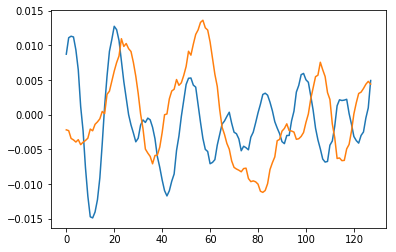

In [21]:
from matplotlib import pyplot as plt

idx = 85000
data, mod, snr = X_test[idx], Y_test[idx], Z_test[idx]
plt.figure()
plt.plot(np.transpose(data))
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

# Quantize dataset

Modulation: AM-DSB, SNR: 2.0 dB


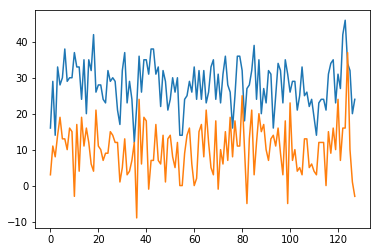

In [8]:
def quantize(data, quant_min, quant_max):
    quant_range = quant_max - quant_min
    data_quant = (data - quant_min) / quant_range
    data_quant = np.round(data_quant * 256) - 128
    data_quant = data_quant.astype(np.int8)
    return data_quant

#whole validation set:
quant_min = -0.03359786
quant_max = 0.03333434
X_test = quantize(X_test, quant_min, quant_max)

idx = 15720
data, mod, snr = X_test[idx], Y_test[idx], Z_test[idx]
plt.figure()
plt.plot(np.transpose(data))
print("Modulation: %s, SNR: %.1f dB" % (mod_classes[mod], snr))

# Classify a single sample

In [9]:
accel_in = data.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 16, 16, 1) and datatype is int8


In [10]:
accel_out = accel.execute(accel_in)

In [11]:
print("Result: " + str(accel_out))
print("Top-1 class predicted by the accelerator: " + mod_classes[np.argmax(accel_out)])

Result: [[-1036.  1042. -1197.  -820. -1094.  -322.  -693. -1029. -1209. -1116.
    846.]]
Top-1 class predicted by the accelerator: AM-DSB


In [12]:
%%timeit
accel_out = accel.execute(accel_in)

100 loops, best of 3: 16 ms per loop


# Validate accuracy on entire validation set

In [13]:
batch_size = 1000
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_folded), str(accel.oshape_folded)) )
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_normal), str(accel.oshape_normal)) )

Accelerator buffer shapes are (1000, 16, 16, 1, 1) for input, (1000, 11, 2) for output
Accelerator buffer shapes are (1000, 16, 16, 1, 1) for input, (1000, 11, 1) for output
Accelerator buffer shapes are (1000, 16, 16, 1) for input, (1000, 11) for output


In [14]:
ok = 0
nok = 0
for i in range(int(X_test.shape[0]/batch_size)):
    batch_idx = i*batch_size
    data, mod, snr = X_test[batch_idx:batch_idx+batch_size], Y_test[batch_idx:batch_idx+batch_size], Z_test[batch_idx:batch_idx+batch_size]

    ibuf_normal = data.reshape(accel.ishape_normal)
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size, -1)
    
    #print(obuf_normal.shape)
    #print(mod)
    #print(obuf_normal)
    
    pred = obuf_normal.argmax(axis=1)
    ok += np.equal(pred, mod).sum().item()
    nok += np.not_equal(pred, mod).sum().item()
        
    #ret = np.bincount(obuf_normal.flatten() == mod.flatten())
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

batch 0 : total OK 0 NOK 1000
batch 1 : total OK 0 NOK 2000
batch 2 : total OK 0 NOK 3000
batch 3 : total OK 0 NOK 4000
batch 4 : total OK 11 NOK 4989
batch 5 : total OK 361 NOK 5639
batch 6 : total OK 957 NOK 6043
batch 7 : total OK 1590 NOK 6410
batch 8 : total OK 2235 NOK 6765
batch 9 : total OK 2885 NOK 7115
batch 10 : total OK 2990 NOK 8010
batch 11 : total OK 3095 NOK 8905
batch 12 : total OK 3432 NOK 9568
batch 13 : total OK 4084 NOK 9916
batch 14 : total OK 4828 NOK 10172
batch 15 : total OK 5591 NOK 10409
batch 16 : total OK 6422 NOK 10578
batch 17 : total OK 7013 NOK 10987
batch 18 : total OK 7525 NOK 11475
batch 19 : total OK 8036 NOK 11964
batch 20 : total OK 8959 NOK 12041
batch 21 : total OK 9892 NOK 12108
batch 22 : total OK 10815 NOK 12185
batch 23 : total OK 11738 NOK 12262
batch 24 : total OK 12660 NOK 12340
batch 25 : total OK 13574 NOK 12426
batch 26 : total OK 14502 NOK 12498
batch 27 : total OK 15428 NOK 12572
batch 28 : total OK 16366 NOK 12634
batch 29 : total O

In [15]:
total = X_test.shape[0]
acc = 100.0 * ok / (total)
print("Overall top-1 accuracy: {}%".format(acc))

Overall top-1 accuracy: 48.483636363636364%


## More benchmarking

In [16]:
accel.batch_size = 1000
accel.throughput_test()

{'DRAM_in_bandwidth[Mb/s]': 0.12951541193874017,
 'DRAM_out_bandwidth[Mb/s]': 0.011130230713485482,
 'batch_size': 1000,
 'copy_input_data_to_device[ms]': 0.0003600120544433594,
 'copy_output_data_from_device[ms]': 7.772445678710938e-05,
 'fclk[mhz]': 99.999,
 'fold_input[ms]': 4.220008850097656e-05,
 'pack_input[ms]': 6.556510925292969e-05,
 'runtime[ms]': 1976.5987396240234,
 'throughput[images/s]': 505.91957788570375,
 'unfold_output[ms]': 6.604194641113281e-05,
 'unpack_output[ms]': 2.965097188949585}